For Fisher, we need three things:
* parameters
* deterministic model
* data model

## Toy model: sum of two exponentials

$$f(t; \theta)=ae^{−bt}+ce^{−dt}$$

$$\theta = [a, b, c, d] \in \mathbb{R}^4$$

Assume observations:

$y_k = f(t_k; \theta) + \epsilon_k, \quad \epsilon_k\sim\mathcal{N}(0, \sigma^2)$

Making model:

$p(y|\theta) \propto \operatorname{exp}(\frac{1}{2\sigma^2}\Sigma_k (y_k - f_k)^2)$


#### gradient of log likelihood:
$\partial_\mu \operatorname{log} p = \frac{1}{\sigma^2} \Sigma_k (y_k - f_k) \partial_\mu f_k$

#### Fisher

$F_{\mu\nu} = \mathbb{E}[\partial_\mu \operatorname{log} p \partial_\nu \operatorname{log} p]$

$ = \mathbb{E}[\frac{1}{\sigma^2} \Sigma_k (y_k - f_k) \partial_\mu f_k * \frac{1}{\sigma^2} \Sigma_k (y_k - f_k) \partial_\nu f_k]$

$ = \frac{1}{\sigma^4}\Sigma_k \Sigma_l (\partial_\mu f_k) (\partial_\nu f_k) \mathbb{E}[(y_k - f_k) (y_k - f_k) ] = \frac{1}{\sigma^4}\Sigma_k \Sigma_l (\partial_\mu f_k) (\partial_\nu f_l) \sigma^2\delta_{kl}​ = \frac{1}{\sigma^2}\Sigma_k(\partial_\mu f_k) (\partial_\nu f_k)$

$ = J^\top J$

ONLY TRUE WITH INDEPENENT GAUSSIAN NOISE!

Why this model?

Has many geometric pathologies:
* curvature
* degeneracy
* parameter collapse
* boundary (when b=d)
* optimization flow
* eigenvalue spectra of Fisher


concept	appears?
curved manifold	yes
sloppiness	yes
singular metric	yes
bifurcation-like degeneracy	yes
multiple time scales

### 1. Compute Fisher eigenvalues in parameter space

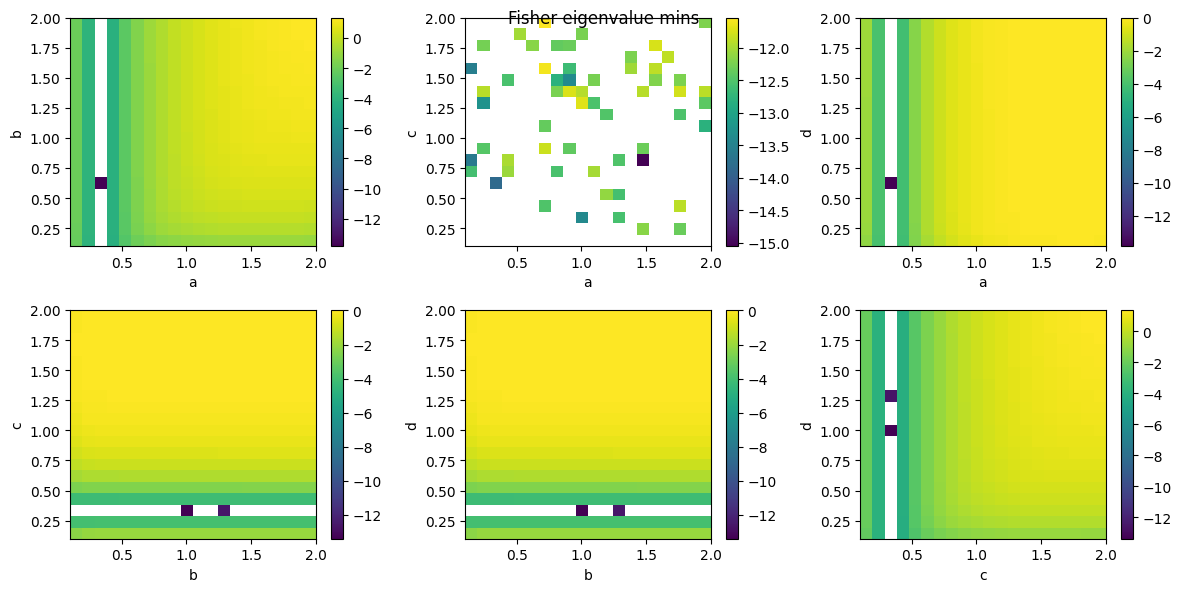

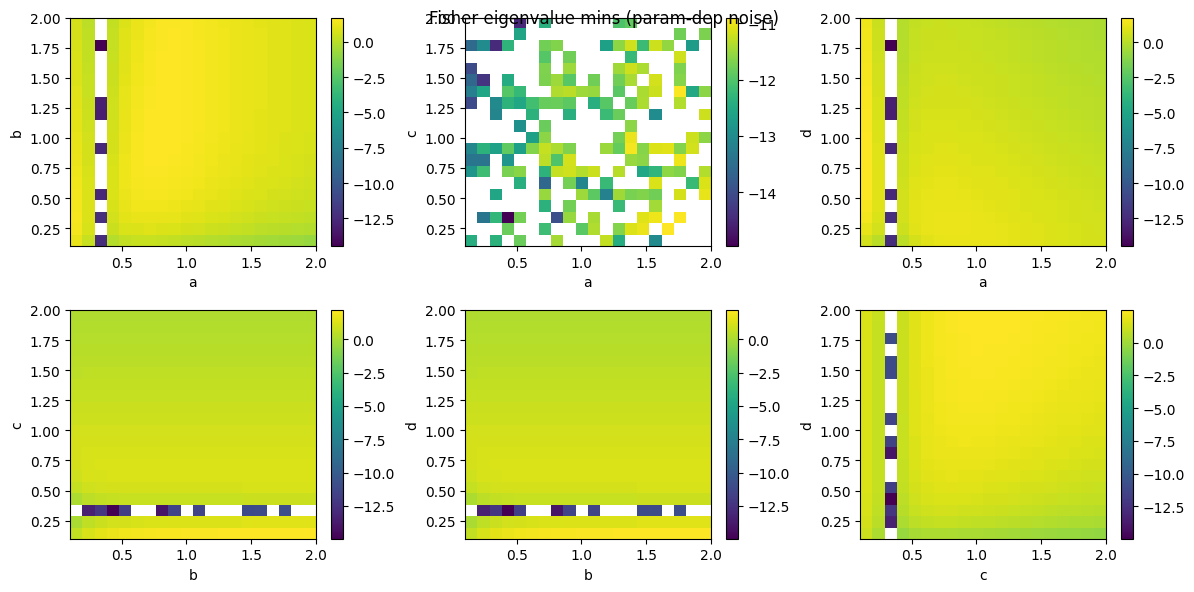

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def sigma2(a, alpha, sigma0):
    return sigma0**2 * (1 + alpha*a**2)

def f(t, theta):
    a, b, c, d = theta
    return a*np.exp(-b*t) + c*np.exp(-d*t)

def jacobian(t, theta):
    a, b, c, d = theta

    dfda = np.exp(-b*t)
    dfdb = -t * a * np.exp(-b*t)
    dfdc = np.exp(-d*t)
    dfdd = -t * c * np.exp(-d*t)

    J = np.zeros((len(t),4))
    J[:,0] = dfda
    J[:,1] = dfdb
    J[:,2] = dfdc
    J[:,3] = dfdd

    return J

def fisher(t, theta, sigma, param_dep_noise=False):
    J = jacobian(t, theta)
    if not param_dep_noise:
        return (J.T @ J) / sigma**2
    
    a,b,c,d = theta
    
    alpha = 2.0

    s2 = sigma2(a, alpha, sigma)
    invC = 1/s2

    # mean term
    F = invC * (J.T @ J)

    # covariance derivative term
    ds2_da = sigma**2 * (2*alpha*a)

    Cinv = 1/s2
    term = 0.5 * len(t) * (Cinv * ds2_da * Cinv)**2

    F[0,0] += term  # only a affects covariance

    return F

def covariance(t,b,d,sigma=0.1,rho=0.9):
    # noise along component 1 correlates with noise along component 2
    # rho=0 independent noise
    # rho>0 components fluctuate together
    # rho<0 components fluctuate oppositely

    v1 = np.exp(-b*t)
    v2 = np.exp(-d*t)

    # normalize
    v1 = v1/np.linalg.norm(v1)
    v2 = v2/np.linalg.norm(v2)

    C = sigma**2*np.eye(len(t))
    C += rho*sigma**2*np.outer(v1,v2)
    C += rho*sigma**2*np.outer(v2,v1)

    return C

def fisher_corr(t, theta,sigma=0.1,rho=0.9):
    a,b,c,d = theta
    Jm = jacobian(t, theta)
    C = covariance(t,b,d,sigma,rho)
    Cinv = np.linalg.inv(C)

    return Jm.T @ Cinv @ Jm


t = np.linspace(0,5,200)
sigma = 0.1

# sweep parameter space 
aas = np.linspace(0.1,2,20)
bs = np.linspace(0.1,2,20)
cs = np.linspace(0.1,2,20)
ds = np.linspace(0.1,2,20)


eigmins = np.zeros((len(aas), len(bs), len(cs), len(ds)))
eigmaxes = np.zeros((len(aas), len(bs), len(cs), len(ds)))
eigmins_param_dep_noise = np.zeros((len(aas), len(bs), len(cs), len(ds)))
eigmins_corr_noise = 
for ii, a in enumerate(aas):
    for i,b in enumerate(bs):
        for jj, c in enumerate(cs):
            for j,d in enumerate(ds):
                theta = (a, b, c, d)
                F = fisher(t, theta, sigma, param_dep_noise=False)
                evs = np.linalg.eigvalsh(F)
                eigmins[ii, i, jj ,j] = np.min(evs)
                eigmaxes[ii, i, jj ,j] = np.max(evs)

                F = fisher(t, theta, sigma, param_dep_noise=True)
                eigmins_param_dep_noise[ii, i, jj ,j] = np.min(np.linalg.eigvalsh(F))

                fisher_corr

def plot_eigvalues(eigmins, title, def1=2, def2=4):
    fig, axes = plt.subplots(2, 3, figsize=(12,6))

    ax = axes[0][0]
    x = eigmins[:, :, def1, def2]
    im = ax.imshow(np.log10(x, where=x>0, out=np.full(x.shape, np.inf)),origin="lower",
            extent=[aas.min(),aas.max(),bs.min(),bs.max()],
            aspect="auto")
    ax.set_xlabel("a")
    ax.set_ylabel("b")
    cbar = fig.colorbar(im, ax=ax)

    ax = axes[0][1]
    x = eigmins[:, def1, :, def2]
    im = ax.imshow(np.log10(x, where=x>0, out=np.full(x.shape, np.inf)),origin="lower",
            extent=[aas.min(),aas.max(),cs.min(),cs.max()],
            aspect="auto")
    ax.set_xlabel("a")
    ax.set_ylabel("c")
    cbar = fig.colorbar(im, ax=ax)

    ax = axes[0][2]
    x = eigmins[:, def1, def2, :]
    im = ax.imshow(np.log10(x, where=x>0, out=np.full(x.shape, np.inf)),origin="lower",
            extent=[aas.min(),aas.max(),ds.min(),ds.max()],
            aspect="auto")
    ax.set_xlabel("a")
    ax.set_ylabel("d")
    cbar = fig.colorbar(im, ax=ax)

    ax = axes[1][0]
    x = eigmins[def1, :, :, def2]
    im = ax.imshow(np.log10(x, where=x>0, out=np.full(x.shape, np.inf)),origin="lower",
            extent=[bs.min(),bs.max(),cs.min(),cs.max()],
            aspect="auto")
    ax.set_xlabel("b")
    ax.set_ylabel("c")
    cbar = fig.colorbar(im, ax=ax)

    ax = axes[1][1]
    x = eigmins[def1, :, :, def2]
    im = ax.imshow(np.log10(x, where=x>0, out=np.full(x.shape, -np.inf)),origin="lower",
            extent=[bs.min(),bs.max(),ds.min(),ds.max()],
            aspect="auto")
    ax.set_xlabel("b")
    ax.set_ylabel("d")
    cbar = fig.colorbar(im, ax=ax)

    ax = axes[1][2]
    x = eigmins[def1, def2, :, :]
    im = ax.imshow(np.log10(x, where=x>0, out=np.full(x.shape, -np.inf)),origin="lower",
            extent=[cs.min(),cs.max(),ds.min(),ds.max()],
            aspect="auto")
    ax.set_xlabel("c")
    ax.set_ylabel("d")
    cbar = fig.colorbar(im, ax=ax)


    # ax.set_colorbar(label="log10 smallest eigenvalue")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
plot_eigvalues(eigmins, "Fisher eigenvalue mins", def1=2, def2=2)
plot_eigvalues(eigmins_param_dep_noise, "Fisher eigenvalue mins (param-dep noise)", def1=2, def2=2)

note where fold happens above ^^ b=d

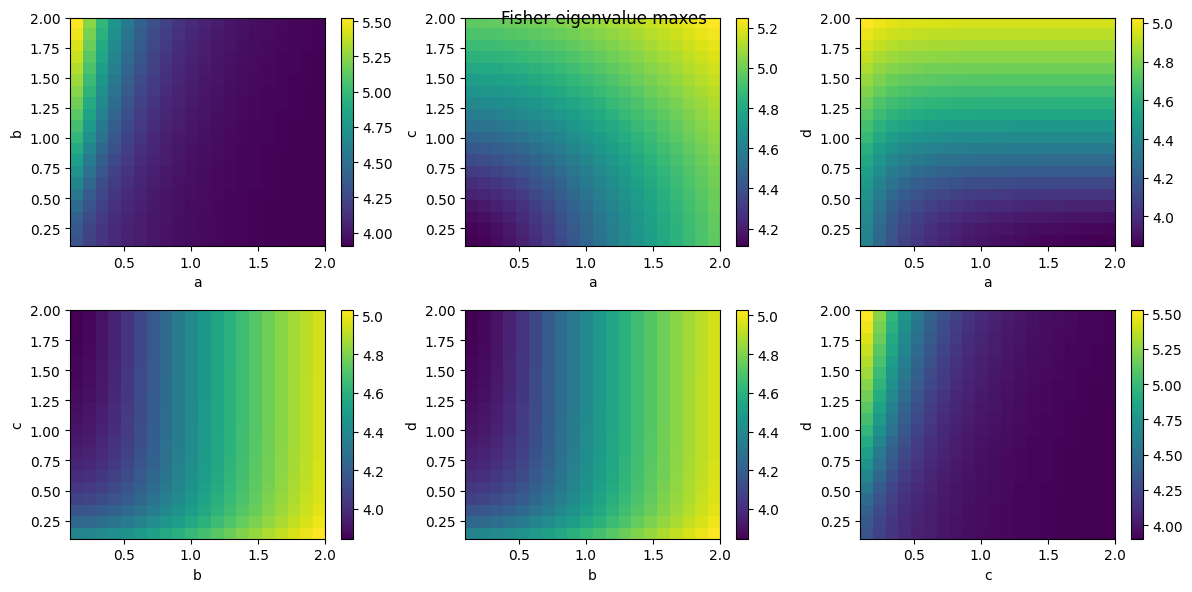

In [101]:
plot_eigvalues(eigmaxes, "Fisher eigenvalue maxes", def1=2, def2=2)

/var/folders/24/lp6939qs6f1d149198s_3mv40000gn/T/ipykernel_40542/43492968.py:53: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(eigmins),origin="lower",


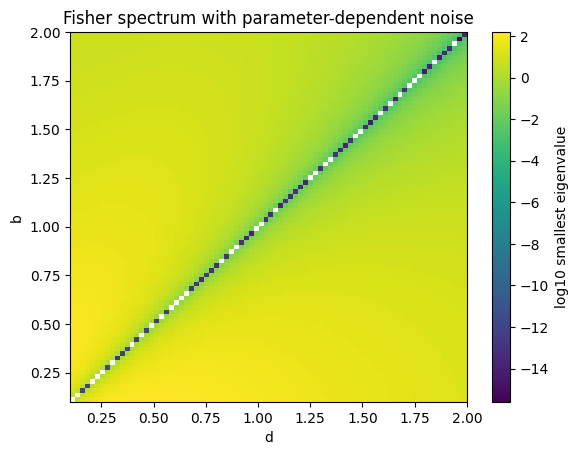

In [98]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 5, 200)

sigma0 = 0.1
alpha = 2.0


def sigma2(a):
    return sigma0**2 * (1 + alpha * a**2)


def f(t, a, b, c, d):
    return a * np.exp(-b * t) + c * np.exp(-d * t)


def jacobian(t, a, b, c, d):
    J = np.zeros((len(t), 4))
    J[:, 0] = np.exp(-b * t)
    J[:, 1] = -a * t * np.exp(-b * t)
    J[:, 2] = np.exp(-d * t)
    J[:, 3] = -c * t * np.exp(-d * t)
    return J


def fisher(a, b, c, d):
    J = jacobian(t, a, b, c, d)

    s2 = sigma2(a)
    invC = 1 / s2

    # mean term
    F = invC * (J.T @ J)

    # covariance derivative term
    ds2_da = sigma0**2 * (2 * alpha * a)

    Cinv = 1 / s2
    term = 0.5 * len(t) * (Cinv * ds2_da * Cinv) ** 2

    F[0, 0] += term  # only a affects covariance

    return F


# sweep
bs = np.linspace(0.1, 2, 80)
ds = np.linspace(0.1, 2, 80)

eigmins = np.zeros((len(bs), len(ds)))

for i, b in enumerate(bs):
    for j, d in enumerate(ds):
        F = fisher(1, b, 1, d)
        eigmins[i, j] = np.min(np.linalg.eigvalsh(F))

plt.imshow(
    np.log10(eigmins),
    origin="lower",
    extent=[ds.min(), ds.max(), bs.min(), bs.max()],
    aspect="auto",
)
plt.colorbar(label="log10 smallest eigenvalue")
plt.xlabel("d")
plt.ylabel("b")
plt.title("Fisher spectrum with parameter-dependent noise")
plt.show()


[3.06274833e-02 3.38885809e+01 1.01558275e+03 5.43866538e+03]
[1.5457209  0.7555476  1.22638716 0.76244857]
[-2.11564382e-12  6.51692325e-02  1.93958648e+03  1.21238000e+04]
[2.1114045  0.75724493 1.6872002  0.43434719]
[2.34082951e-02 4.50678927e+02 3.71593082e+03 4.10822102e+04]
[2.6735553  0.52856773 2.19068113 0.29943919]
[7.42032333e-03 9.05039170e+02 5.65160852e+03 1.49534743e+05]
[3.23788045 0.23609835 2.66913754 0.21530682]
[1.04222334e-08 4.20369828e+01 6.05887847e+03 6.04035244e+05]
[3.80356151 0.19177794 3.22863241 0.14455278]
[3.06274833e-02 3.38885809e+01 1.01558275e+03 5.43866538e+03]
[1.19488544 1.52638864 1.17315697 1.51070329]
[3.21435113e-12 1.09971036e-02 3.55870837e+02 3.16301739e+03]
[1.19113256 2.09153007 1.69343962 1.73410214]
[9.03908000e-05 2.09735200e+00 3.29477974e+02 2.57053306e+03]
[1.13948357 2.4443257  2.35079775 2.01826388]
[8.85887670e-05 1.41826205e+00 3.50776712e+02 2.30709833e+03]
[1.09540761 2.70185901 3.02569799 2.359209  ]
[9.98937168e-06 5.194270

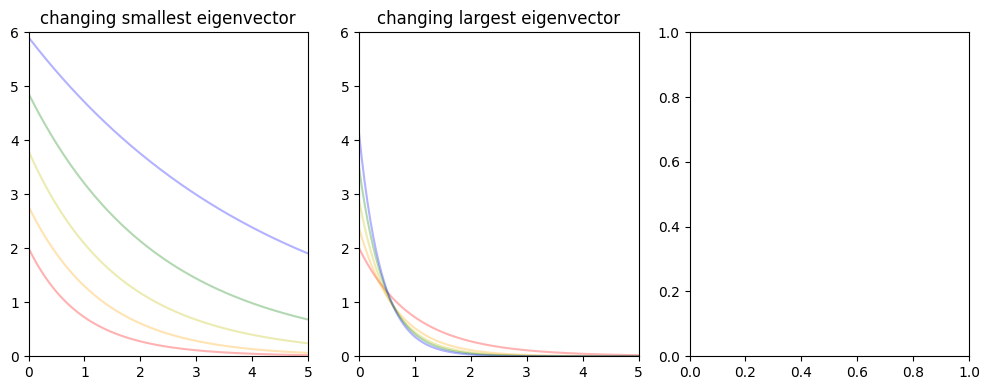

In [94]:
import matplotlib.animation as animation

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

alpha = 0.8

a, b, c, d = 1, 0.8, 1, 1.3
theta = np.array([a, b, c, d])

cs = ["r", "orange", "y", "g", "b", "p"]
for i in range(5):
    F = fisher(t, theta, sigma)
    eigvals, eigvecs = np.linalg.eigh(F)
    print(eigvals)

    axes[0].plot(t, f(t, theta), c=cs[i], alpha=0.3)

    theta += alpha * eigvecs[0]
    print(theta)
axes[0].set_title("changing smallest eigenvector")
axes[0].set_xlim((0, 5))
axes[0].set_ylim((0, 6))

a, b, c, d = 1, 0.8, 1, 1.3
theta = np.array([a, b, c, d])
vals = []
for i in range(5):
    F = fisher(t, theta, sigma)
    eigvals, eigvecs = np.linalg.eigh(F)
    print(eigvals)

    axes[1].plot(t, f(t, theta), c=cs[i], alpha=0.3)
    vals.append(f(t, theta))
    axes[1].set_title("changing largest eigenvector")

    theta += alpha * eigvecs[3]
    print(theta)
axes[1].set_xlim((0, 5))
axes[1].set_ylim((0, 6))

plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(1, 3, figsize=(10,4))


a, b, c, d = 1, 1.29, 1, 1.3
alpha = 0.1
theta = np.array([a, b, c, d])
curves = []
thetas0 = [np.array([a, b, c, d])]
thetas3 = [np.array([a, b, c, d])]
for i in range(100):
    F = fisher(t, theta, sigma)
    eigvals, eigvecs = np.linalg.eigh(F)
    theta += alpha * eigvecs[0]
    thetas0.append(thetas0[-1] + alpha * eigvecs[0])
    thetas3.append(thetas3[-1] + alpha * eigvecs[3])
    curves.append(f(t, theta))

(line0,) = axes[0].plot(t, f(t, theta))
(line3,) = axes[1].plot(t, f(t, theta))
axes[0].set_xlim((0, 5))
axes[0].set_ylim((-2, 15))


def update(frame):
    # print(frame)
    line0.set_ydata(f(t, thetas0[frame]))
    line3.set_ydata(f(t, thetas3[frame]))
    # axes[0].set_title(f"{thetas[frame]}")
    return line0, line3


ani = animation.FuncAnimation(fig, update, frames=100, interval=5)
ani.save("fisher.gif", writer="pillow", fps=10)
plt.show()
plt.close()


In [95]:
thetas0

[array([1.  , 1.29, 1.  , 1.3 ]),
 array([1.0707098 , 1.29009385, 1.02753784, 1.23487102]),
 array([1.14139581, 1.28942917, 1.05934024, 1.17169149]),
 array([1.21200331, 1.28767007, 1.09524037, 1.11067784]),
 array([1.28249807, 1.28447826, 1.13506078, 1.05207206]),
 array([1.35286142, 1.27953756, 1.17860554, 0.99613959]),
 array([1.42308646, 1.27257572, 1.22564989, 0.94316029]),
 array([1.49317531, 1.26338342, 1.27592775, 0.89340899]),
 array([1.56313732, 1.25182866, 1.32912063, 0.84712377]),
 array([1.63298782, 1.2378637 , 1.3848536 , 0.80446555]),
 array([1.70274686, 1.22152184, 1.44270515, 0.7654807 ]),
 array([1.77243783, 1.20290381, 1.5022324 , 0.73008234]),
 array([1.84208563, 1.1821568 , 1.56300511, 0.69806009]),
 array([1.91171488, 1.15945173, 1.62463618, 0.66911434]),
 array([1.98134839, 1.1349638 , 1.68679989, 0.64290003]),
 array([2.05100603, 1.1088593 , 1.74923613, 0.61906551]),
 array([2.12070424, 1.08128877, 1.81174508, 0.59727891]),
 array([2.19045594, 1.05238536, 1.8741

In [97]:
thetas3

[array([1.  , 1.29, 1.  , 1.3 ]),
 array([1.00035556, 1.3612453 , 1.0644546 , 1.32774139]),
 array([0.99851563, 1.43035025, 1.13007683, 1.3579878 ]),
 array([0.99485353, 1.49692423, 1.19683916, 1.39111308]),
 array([0.98972765, 1.56062231, 1.26459647, 1.42751674]),
 array([0.98346994, 1.62115501, 1.33307442, 1.46760917]),
 array([0.97637832, 1.67830314, 1.4018662 , 1.51178488]),
 array([0.96871259, 1.73193567, 1.47044575, 1.5603815 ]),
 array([0.96069306, 1.78202621, 1.53820603, 1.61362782]),
 array([0.95250116, 1.82866104, 1.60452471, 1.67159263]),
 array([0.94428174, 1.87203362, 1.66884661, 1.73415422]),
 array([0.93614649, 1.91242441, 1.73075841, 1.80100727]),
 array([0.92817842, 1.95017095, 1.79002984, 1.8717081 ]),
 array([0.92043679, 1.98563643, 1.84661178, 1.94574019]),
 array([0.91296212, 2.01918396, 1.90060154, 2.02257637]),
 array([0.90578082, 2.05115975, 1.95219565, 2.10172196]),
 array([0.89890903, 2.08188525, 2.00164621, 2.18273656]),
 array([0.8923557 , 2.11165563, 2.0492

Step 2 — simulate optimization flow

Compare:

gradient descent

natural gradient

Visualize trajectories on manifold.

So natural gradient amplifies sloppy directions.

Step 3 — locate boundaries

Solve
det
⁡
𝐹
(
𝜃
)
=
0.
detF(θ)=0.

That defines singular set.

Step 4 — local geometry analysis

Compute:

Christoffel symbols

curvature tensor

See where curvature spikes.



Optimization is not moving in parameter space.

It is moving in:

statistical distinguishability space.


Sloppy models behave like:

thin sheets embedded in high-dimensional space.

Optimization difficulty = trying to move along thin directions without falling off edges.